Image:  test_images\solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


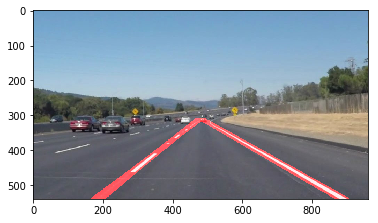

Image:  test_images\solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


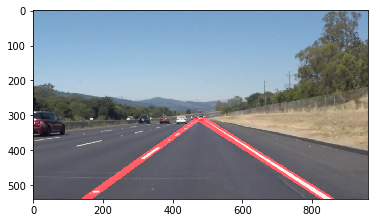

Image:  test_images\solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


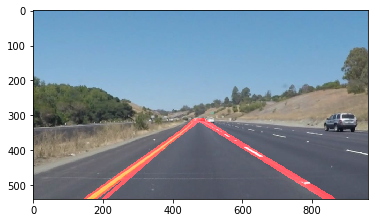

Image:  test_images\solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


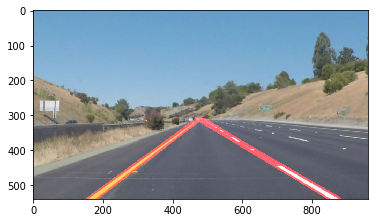

Image:  test_images\solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


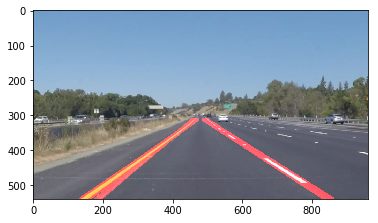

Image:  test_images\whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


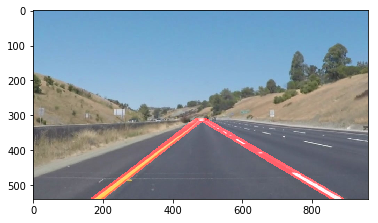

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████████████████████████████████████▊| 221/222 [00:07<00:00, 28.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8.76 s
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████████████████████████████████████▉| 681/682 [00:24<00:00, 27.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 25.7 s
[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████████████████████████████████████| 251/251 [00:17<00:00, 14.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

Wall time: 19.2 s


In [1]:
#!/usr/bin/env python
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
import glob
from numpy.polynomial import polynomial
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
        
def grayscale(image):
    # change the image into grayscale with one color channel
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

def canny(image, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(image, low_threshold, high_threshold)

def gaussianblur(image,kernel_size):
    """Applies a Gaussian Noise kernel"""
    # Apply Gaussian smoothing with Kernel_size
    return cv2.GaussianBlur(image,(kernel_size, kernel_size),0)

def region_of_interest(image):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    #Creating Mask 
    mask = np.zeros_like(image)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    left_top = [0.44*imshape[1],0.58*imshape[0]]
    left_bottom = [0.18*imshape[1],imshape[0]]
    right_top = [0.52*imshape[1],0.58*imshape[0]]
    right_bottom =[imshape[1],imshape[0]]
    vertices = np.array([[(left_bottom[0],left_bottom[1]),(left_top[0],left_top[1]),(right_top[0],right_top[1]),(right_bottom[0],right_bottom[1])]], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    return cv2.bitwise_and(image, mask)


def draw_lines(image,lines):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    color = (255,0,0) # scalar value for grayscale 
    thickness = 10 #thickness of the line
    # Iterate over the output "lines" and draw color lines with mentioned thickness on a blank image 
    for line in lines:
        x1 = line[0]
        y1 = line[1]
        x2 = line[2]
        y2 = line[3]
        #for x1,y1,x2,y2 in line:  
        cv2.line(image,(int(math.floor(x1)),int(math.floor(y1))),(int(math.floor(x2)),int(math.floor(y2))),color,thickness)

        
def extrapolate(lane_lines,m,image):
    """
    NOTE: this is the function that extrapolate the line segments 
    to map out the full extent of the lane from top and bottom 
    of the lane within the region of interest.
    """
    
    lanes = []
    imshape = image.shape
    #Region of interest
    YTop = 0.58*imshape[0]
    YBottom = imshape[0]
    XBleft = 0.08*imshape[1]
    XBright = 0.98*imshape[1]
    XTleft = 0.40*imshape[1]
    XTright = 0.52*imshape[1] 
    #Extrapolate the line segments
    for line in lane_lines:
        x1=line[0]
        y1=line[1]
        x2=line[2]
        y2=line[3]
        slope = line[4]
        if (abs(slope)>0.5):
            x2New = x1 + (YTop-y1)/slope
            x1New = x2 - (y2-YBottom)/slope  
            if ((x1New>XBleft and x1New<XBright)and(x2New>XTleft and x2New<XTright)):
                #Making sure the points are within region of interest
                lanes.append([x1New,YBottom,x2New,YTop])
    return lanes
    

def lane_differentiation(lines):
    """
    separating line segments by their slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, average the position of each of the lines to idetinfy the average left vs right slope.
    """
    #positive slope for left side of polygon-> x is directly proportional to y --> Left Lanes
    #negative slope for right side of polygon-> x is inversely proportional to y --> Right Lanes
    right_lines = []
    left_lines = []
    number_right = 0
    number_left = 0
    mtotal_right = 0
    mtotal_left = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            if (m>=0):
                left_lines.append([x1,y1,x2,y2,m])
                mtotal_left = m + mtotal_left
                number_left = number_left + 1
            else:
                right_lines.append([x1,y1,x2,y2,m])
                mtotal_right = m + mtotal_right
                number_right = number_right + 1
    #average slope            
    m_Right = mtotal_right/number_right
    m_Left = mtotal_left/number_left
    return m_Right, m_Left,right_lines,left_lines

def hough_lines(masked_edges,image):    
    """
    `image` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    # creating a blank to draw lines on
    line_image = np.copy((image)*0)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)    
    #Differentiating left/right Lines
    m_Right, m_Left,right_lines,left_lines =lane_differentiation(lines)
    right = np.array(extrapolate(right_lines,m_Right,image))
    left = np.array(extrapolate(left_lines,m_Left,image))
    #draw_lines(line_image,lines)
    draw_lines(line_image,right)
    draw_lines(line_image,left)
    return line_image

def process_image(image):
    ################Step 1#####################
    # Read in and grayscale the image
    gray = grayscale(image)
    ################Step 2#####################
    #apply Gaussian smoothing
    blur_gray = gaussianblur(gray, kernel_size)
    ################Step 3#####################
    #Apply Canny Edge for edge detection
    edges = canny(blur_gray,low_threshold,high_threshold)
    ################Step 4#####################
    #Create region of interest
    masked_edges = region_of_interest(edges)
    ################Step 5#####################
    # Run Hough on edge detected image
    # Output "line_image" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges,image)
    ################Step 6#####################
    # Draw the lines on the original image
    result = cv2.addWeighted(line_image, 0.8, image, 1, 0) 
    return result
    ###########################################


##################Global Parameters################    
# Defining a kernel size to apply Gaussian smoothing
kernel_size = 5
# Defining threshold parameters for Canny 
low_threshold = 50 # below color ignored
high_threshold = 150 #above colors ignored
# Defining the Hough transform parameters
# Make a blank the same size as    our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 25     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50 #minimum number of pixels making up a line
max_line_gap = 150   # maximum gap in pixels between connectable line segments

#######################################################################
#reading in the test images
for images in glob.glob('test_images/*'):
    # Read in the image and print out some stats
    print ('Image: ', images)
    image = mpimg.imread(images)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    test_image = process_image(image)  
    plt.imshow(test_image)
    plt.show()    
####################################################################### 
#Processing solidWhiteRight.mp4 video
white_output = 'white.mp4'
clipWhite = VideoFileClip('solidWhiteRight.mp4')
white_clip = clipWhite.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False) 
#######################################################################
#Processing solidYellowLeft.mp4 video
yellow_output = 'yellow.mp4'
clipYellow = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clipYellow.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
#########################################################
challenge_output = 'challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)